Guidance for Reproducting Results:


1.   **Training Model**: Run all cells between beginning and "Main Training Cell". Set up configuration for the Main training cell: Choose number of iterations and initialisation. Set the correct path for saving check points for the model
2.   **Load Trained Model**: Run all cells from beginning and BEFORE "Main Training Cell". Next, start from "Load Saved Model and Make Predictions", modify the file path to the models desired, then run all cells after.

# Load and process data

In [ ]:
!pip install gpytorch

In [ ]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/train_set.csv', index_col = 0)
test_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/test_set.csv', index_col = 0)
data = pd.concat([train_data,test_data], axis = 0)

In [ ]:
# Get the list of all columns
all_columns = data.columns.tolist()

# Columns to exclude from scaling
exclude_columns = ['Date.time', 'turbine', 'year']

# Columns to be standardized (input features + output)
columns_to_standardize = [col for col in all_columns if col not in exclude_columns]

# Dictionary to store mean and standard deviation for each turbine and column
turbine_standardization_parameters = {}

# Loop through each turbine
for turbine_id in data['turbine'].unique():
    turbine_data = data[data['turbine'] == turbine_id]
    standardization_parameters = {}

    for col in columns_to_standardize:
        mean = turbine_data[col].mean()
        std = turbine_data[col].std()

        # Standardize the data for this turbine
        data.loc[data['turbine'] == turbine_id, col] = (turbine_data[col] - mean) / std

        # Save the parameters
        standardization_parameters[col] = {'mean': mean, 'std': std}

    # Store the parameters for this turbine
    turbine_standardization_parameters[turbine_id] = standardization_parameters

In [ ]:
turbine_1 = data[data['turbine'] == 1].reset_index()
turbine_2 = data[data['turbine'] == 2].reset_index()
turbine_3 = data[data['turbine'] == 3].reset_index()
turbine_4 = data[data['turbine'] == 4].reset_index()
turbine_5 = data[data['turbine'] == 5].reset_index()
turbine_6 = data[data['turbine'] == 6].reset_index()

In [ ]:
a = 932
train_turbine_1, test_turbine_1 = turbine_1.iloc[:3000].reset_index(drop=True), turbine_1.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_2, test_turbine_2 = turbine_2.iloc[:3000].reset_index(drop=True), turbine_2.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_3, test_turbine_3 = turbine_3.iloc[:3000].reset_index(drop=True), turbine_3.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_4, test_turbine_4 = turbine_4.iloc[:3000].reset_index(drop=True), turbine_4.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_5, test_turbine_5 = turbine_5.iloc[:3000].reset_index(drop=True), turbine_5.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_6, test_turbine_6 = turbine_6.iloc[:3000].reset_index(drop=True), turbine_6.iloc[3000:3000+a].reset_index(drop=True)

In [ ]:
features =[
 'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
#  'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
#  'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
 ]

In [ ]:
X_train = pd.concat([train_turbine_1[features], train_turbine_2[features],
                   train_turbine_3[features], train_turbine_4[features],
                   train_turbine_5[features], train_turbine_6[features]])

Y_train = pd.concat([train_turbine_1['Power.me'], train_turbine_2['Power.me'],
                   train_turbine_3['Power.me'], train_turbine_4['Power.me'],
                   train_turbine_5['Power.me'], train_turbine_6['Power.me']])


train_i_task1 = torch.full((train_turbine_1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_turbine_2.shape[0],1), dtype=torch.long, fill_value=1)
train_i_task3 = torch.full((train_turbine_3.shape[0],1), dtype=torch.long, fill_value=2)
train_i_task4 = torch.full((train_turbine_4.shape[0],1), dtype=torch.long, fill_value=3)
train_i_task5 = torch.full((train_turbine_5.shape[0],1), dtype=torch.long, fill_value=4)
train_i_task6 = torch.full((train_turbine_6.shape[0],1), dtype=torch.long, fill_value=5)

full_train_i = torch.cat([train_i_task1, train_i_task2, train_i_task3,
                          train_i_task4, train_i_task5, train_i_task6])

full_train_x = torch.tensor(X_train.values.astype(float)).float()
full_train_y = torch.tensor(Y_train.values.astype(float)).float()

In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(),ard_num_dims=3)

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=6, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        # print('x:', x.shape)
        # print('i:', x.shape)
        # print('covar_x:', covar_x.shape)
        # print('covar_i:', covar_i.shape)
        # print('covar:', covar.shape)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

In [ ]:
# Function to initialise model and likelihood objects
def create_model_and_likelihood(full_train_x, full_train_y, full_train_i):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)
    return model, likelihood

# Function to save the model and likelihood with an initialization identifier
def save_checkpoint(model, likelihood, iteration, init, folder='/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (1 to 10 - Attempt 5)'):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), f'{folder}/model_state_init{init}_iter{iteration}.pth')
    torch.save(likelihood.state_dict(), f'{folder}/likelihood_state_init{init}_iter{iteration}.pth')

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 600
n_initializations = 5  # Number of initializations
best_loss = float('inf')
best_model = None
best_likelihood = None

# Training loop for multiple initializations
for init in range(1,11):

    model, likelihood = create_model_and_likelihood(full_train_x, full_train_y, full_train_i)

    model.train()
    likelihood.train()

    model = model.float()
    likelihood = likelihood.float()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with tqdm(total=training_iter, desc=f"Training Progress (Init {init})") as pbar:
        for i in range(training_iter):
          optimizer.zero_grad()
          output = model(full_train_x, full_train_i)
          loss = -mll(output, full_train_y)
          loss.backward()
          optimizer.step()

          pbar.set_postfix(loss=loss.item())
          pbar.update(1)

          if i > 400 and (i + 1) % 1 == 0:
              save_checkpoint(model, likelihood, i + 1, init)  # Save checkpoint every 50 iterations for each init

          # Compare and store the best model
          final_loss = loss.item()
          if final_loss < best_loss:
              best_loss = final_loss
              best_model = model
              best_likelihood = likelihood

print(f'Best Loss: {best_loss}')

In [ ]:
model, likelihood = create_model_and_likelihood(full_train_x, full_train_y, full_train_i)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# Load saved model and likelihood
model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (1 to 10 - Attempt 5)/model_state_init6_iter500.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (1 to 10 - Attempt 5)/likelihood_state_init6_iter500.pth'))

<All keys matched successfully>

In [ ]:
# Calculate loss if necessary. Note that this cell shouldn't be run twice because it will explode
# -mll(model(full_train_x, full_train_i), full_train_y)

### Making Prediction

Changing hyperparameters back to float64 is important for gpytorch.settings.fast_pred_var()

In [ ]:
# X_test = pd.concat([test_turbine_1['encoded_input'], test_turbine_2['encoded_input'],
#                    test_turbine_3['encoded_input'], test_turbine_4['encoded_input'],
#                    test_turbine_5['encoded_input'], test_turbine_6['encoded_input']])

# Y_test = pd.concat([test_turbine_1['Power.me'], test_turbine_2['Power.me'],
#                    test_turbine_3['Power.me'], test_turbine_4['Power.me'],
#                    test_turbine_5['Power.me'], test_turbine_6['Power.me']])


test_i_task1 = torch.full((test_turbine_1.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_turbine_2.shape[0],1), dtype=torch.long, fill_value=1)
test_i_task3 = torch.full((test_turbine_3.shape[0],1), dtype=torch.long, fill_value=2)
test_i_task4 = torch.full((test_turbine_4.shape[0],1), dtype=torch.long, fill_value=3)
test_i_task5 = torch.full((test_turbine_5.shape[0],1), dtype=torch.long, fill_value=4)
test_i_task6 = torch.full((test_turbine_6.shape[0],1), dtype=torch.long, fill_value=5)

test_x_turbine_1 = torch.tensor(test_turbine_1[features].values.astype(float)).float()
test_x_turbine_2 = torch.tensor(test_turbine_2[features].values.astype(float)).float()
test_x_turbine_3 = torch.tensor(test_turbine_3[features].values.astype(float)).float()
test_x_turbine_4 = torch.tensor(test_turbine_4[features].values.astype(float)).float()
test_x_turbine_5 = torch.tensor(test_turbine_5[features].values.astype(float)).float()
test_x_turbine_6 = torch.tensor(test_turbine_6[features].values.astype(float)).float()

In [ ]:
model = model.to(torch.float64)
likelihood = likelihood.to(torch.float64)

In [ ]:
# Your existing training code here

# Make predictions on training data for confidence interval
model.eval()
likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     train_observed_pred = likelihood(model.predict(train_x))
#     train_lower, train_upper = train_observed_pred.confidence_region()
#     train_mean = train_observed_pred.mean.detach().numpy()
#     train_variance = train_observed_pred.variance.detach().numpy()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x_turbine_1, test_i_task1))
    observed_pred_y2 = likelihood(model(test_x_turbine_2, test_i_task2))
    observed_pred_y3 = likelihood(model(test_x_turbine_3, test_i_task3))
    observed_pred_y4 = likelihood(model(test_x_turbine_4, test_i_task4))
    observed_pred_y5 = likelihood(model(test_x_turbine_5, test_i_task5))
    observed_pred_y6 = likelihood(model(test_x_turbine_6, test_i_task6))

In [ ]:
mean_pred_y1 = observed_pred_y1.mean.detach().numpy()
mean_pred_y2 = observed_pred_y2.mean.detach().numpy()
mean_pred_y3 = observed_pred_y3.mean.detach().numpy()
mean_pred_y4 = observed_pred_y4.mean.detach().numpy()
mean_pred_y5 = observed_pred_y5.mean.detach().numpy()
mean_pred_y6 = observed_pred_y6.mean.detach().numpy()

var_pred_y1 = observed_pred_y1.variance.detach().numpy()
var_pred_y2 = observed_pred_y2.variance.detach().numpy()
var_pred_y3 = observed_pred_y3.variance.detach().numpy()
var_pred_y4 = observed_pred_y4.variance.detach().numpy()
var_pred_y5 = observed_pred_y5.variance.detach().numpy()
var_pred_y6 = observed_pred_y6.variance.detach().numpy()

test_lower_y1, test_upper_y1 = observed_pred_y1.confidence_region()
test_lower_y2, test_upper_y2 = observed_pred_y2.confidence_region()
test_lower_y3, test_upper_y3 = observed_pred_y3.confidence_region()
test_lower_y4, test_upper_y4 = observed_pred_y4.confidence_region()
test_lower_y5, test_upper_y5 = observed_pred_y5.confidence_region()
test_lower_y6, test_upper_y6 = observed_pred_y6.confidence_region()

### Rescale Power.me to before standardisation

In [ ]:
def rescale_to_original(value, turbine_id, col, dictionary):
    params = dictionary[turbine_id][col]
    return value * params['std'] + params['mean']


# Rescaling mean predictions
mean_pred_y1_og = rescale_to_original(mean_pred_y1, 1, 'Power.me', turbine_standardization_parameters)
mean_pred_y2_og = rescale_to_original(mean_pred_y2, 2, 'Power.me', turbine_standardization_parameters)
mean_pred_y3_og = rescale_to_original(mean_pred_y3, 3, 'Power.me', turbine_standardization_parameters)
mean_pred_y4_og = rescale_to_original(mean_pred_y4, 4, 'Power.me', turbine_standardization_parameters)
mean_pred_y5_og = rescale_to_original(mean_pred_y5, 5, 'Power.me', turbine_standardization_parameters)
mean_pred_y6_og = rescale_to_original(mean_pred_y6, 6, 'Power.me', turbine_standardization_parameters)

# Rescaling variance predictions
var_pred_y1_og = rescale_to_original(var_pred_y1, 1, 'Power.me', turbine_standardization_parameters)
var_pred_y2_og = rescale_to_original(var_pred_y2, 2, 'Power.me', turbine_standardization_parameters)
var_pred_y3_og = rescale_to_original(var_pred_y3, 3, 'Power.me', turbine_standardization_parameters)
var_pred_y4_og = rescale_to_original(var_pred_y4, 4, 'Power.me', turbine_standardization_parameters)
var_pred_y5_og = rescale_to_original(var_pred_y5, 5, 'Power.me', turbine_standardization_parameters)
var_pred_y6_og = rescale_to_original(var_pred_y6, 6, 'Power.me', turbine_standardization_parameters)

# Rescaling test lower bounds
test_lower_y1_og = rescale_to_original(test_lower_y1, 1, 'Power.me', turbine_standardization_parameters)
test_lower_y2_og = rescale_to_original(test_lower_y2, 2, 'Power.me', turbine_standardization_parameters)
test_lower_y3_og = rescale_to_original(test_lower_y3, 3, 'Power.me', turbine_standardization_parameters)
test_lower_y4_og = rescale_to_original(test_lower_y4, 4, 'Power.me', turbine_standardization_parameters)
test_lower_y5_og = rescale_to_original(test_lower_y5, 5, 'Power.me', turbine_standardization_parameters)
test_lower_y6_og = rescale_to_original(test_lower_y6, 6, 'Power.me', turbine_standardization_parameters)

# Rescaling test upper bounds
test_upper_y1_og = rescale_to_original(test_upper_y1, 1, 'Power.me', turbine_standardization_parameters)
test_upper_y2_og = rescale_to_original(test_upper_y2, 2, 'Power.me', turbine_standardization_parameters)
test_upper_y3_og = rescale_to_original(test_upper_y3, 3, 'Power.me', turbine_standardization_parameters)
test_upper_y4_og = rescale_to_original(test_upper_y4, 4, 'Power.me', turbine_standardization_parameters)
test_upper_y5_og = rescale_to_original(test_upper_y5, 5, 'Power.me', turbine_standardization_parameters)
test_upper_y6_og = rescale_to_original(test_upper_y6, 6, 'Power.me', turbine_standardization_parameters)

# Assuming test_turbine_x['Power.me'] contains the scaled observed values for each turbine
obs_y1_og = rescale_to_original(test_turbine_1['Power.me'], 1, 'Power.me', turbine_standardization_parameters)
obs_y2_og = rescale_to_original(test_turbine_2['Power.me'], 2, 'Power.me', turbine_standardization_parameters)
obs_y3_og = rescale_to_original(test_turbine_3['Power.me'], 3, 'Power.me', turbine_standardization_parameters)
obs_y4_og = rescale_to_original(test_turbine_4['Power.me'], 4, 'Power.me', turbine_standardization_parameters)
obs_y5_og = rescale_to_original(test_turbine_5['Power.me'], 5, 'Power.me', turbine_standardization_parameters)
obs_y6_og = rescale_to_original(test_turbine_6['Power.me'], 6, 'Power.me', turbine_standardization_parameters)

### Observing the range and distribution of re-scaled values. Good to check variance and bounds because sometimes they are too large or too small

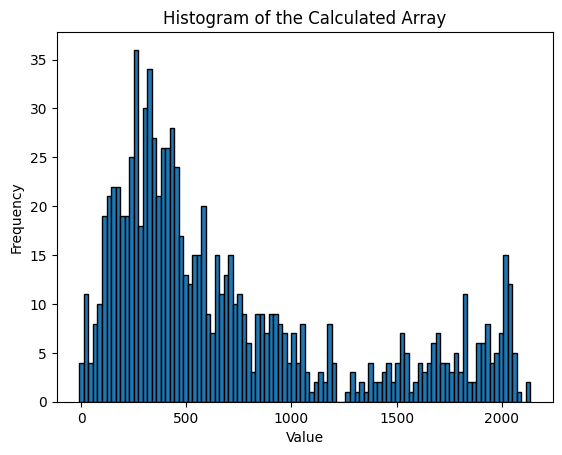

In [ ]:
plt.hist(mean_pred_y1_og, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Calculated Array')
plt.show()

### Calculate Coverage Probability

In [ ]:
# def calculate_coverage_probability(y_true, lower_bound, upper_bound):

#     # Count how many true values fall within the prediction intervals
#     covered = ((y_true >= lower_bound) & (y_true <= upper_bound)).sum()

#     # Calculate the coverage probability
#     coverage_probability = covered / len(y_true)

#     return coverage_probability

# # Calculate coverage probability for training data
# # train_coverage_probability = calculate_coverage_probability(train_y_original, train_lower_original, train_upper_original)

# # Calculate coverage probability for test data
# test_coverage_probability = calculate_coverage_probability(test_y_original, test_lower_original, test_upper_original)

# # Output the results
# # print(f"Training Data Coverage Probability: {train_coverage_probability}")
# print(f"Test Data Coverage Probability: {test_coverage_probability}")

### Calculate RMSE and Standard Error of model on training and testing data

In [ ]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Function to calculate Standard Error
def standard_error(y_true, y_pred):
    std_dev = np.std(y_true - y_pred)
    return std_dev / np.sqrt(len(y_true))

def calculate_nlpd(predicted_mean, predicted_var, actual_y):

    # Calculate the Gaussian PDF value for each test point
    pdf_values = 1 / np.sqrt(2 * np.pi * predicted_var) * np.exp(-0.5 * (actual_y - predicted_mean)**2 / predicted_var)

    pdf_values = pdf_values[pdf_values>0]
    # Calculate the Negative Log-Predictive Density (NLPD)
    nlpd = -np.mean(np.log(pdf_values))

    return nlpd


# Calculate RMSE and NLPD for test data
test_rmse_y1 = rmse(obs_y1_og, mean_pred_y1_og)
test_rmse_y2 = rmse(obs_y2_og, mean_pred_y2_og)
test_rmse_y3 = rmse(obs_y3_og, mean_pred_y3_og)
test_rmse_y4 = rmse(obs_y4_og, mean_pred_y4_og)
test_rmse_y5 = rmse(obs_y5_og, mean_pred_y5_og)
test_rmse_y6 = rmse(obs_y6_og, mean_pred_y6_og)



test_nlpd_y1 = calculate_nlpd(mean_pred_y1_og, var_pred_y1_og , obs_y1_og)
test_nlpd_y2 = calculate_nlpd(mean_pred_y2_og, var_pred_y2_og , obs_y2_og)
test_nlpd_y3 = calculate_nlpd(mean_pred_y3_og, var_pred_y3_og , obs_y3_og)
test_nlpd_y4 = calculate_nlpd(mean_pred_y4_og, var_pred_y4_og , obs_y4_og)
test_nlpd_y5 = calculate_nlpd(mean_pred_y5_og, var_pred_y5_og , obs_y5_og)
test_nlpd_y6 = calculate_nlpd(mean_pred_y6_og, var_pred_y6_og , obs_y6_og)

In [ ]:
print("-------RMSE--------")
print("Turbine 1 RMSE:", test_rmse_y1)
print("Turbine 2 RMSE:", test_rmse_y2)
print("Turbine 3 RMSE:", test_rmse_y3)
print("Turbine 4 RMSE:", test_rmse_y4)
print("Turbine 5 RMSE:", test_rmse_y5)
print("Turbine 6 RMSE:", test_rmse_y6)
print("-------NLPD--------")
print("Turbine 1 NLPD:", test_nlpd_y1)
print("Turbine 2 NLPD:", test_nlpd_y2)
print("Turbine 3 NLPD:", test_nlpd_y3)
print("Turbine 4 NLPD:", test_nlpd_y4)
print("Turbine 5 NLPD:", test_nlpd_y5)
print("Turbine 6 NLPD:", test_nlpd_y6)

-------RMSE--------
Turbine 1 RMSE: 66.88047275352423
Turbine 2 RMSE: 62.42366990234483
Turbine 3 RMSE: 62.59006415382899
Turbine 4 RMSE: 59.54333276227919
Turbine 5 RMSE: 59.75451968902005
Turbine 6 RMSE: 54.90569483478061
-------NLPD--------
Turbine 1 NLPD: 6.917698304126021
Turbine 2 NLPD: 6.32214886551675
Turbine 3 NLPD: 6.586201359074505
Turbine 4 NLPD: 6.3210798268551995
Turbine 5 NLPD: 6.566709085156875
Turbine 6 NLPD: 6.33234586285961


### Making Plots

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Given variables: mean_pred_y*_og, obs_y*_og, test_lower_y*_og, test_upper_y*_og for turbines 1 to 6
# Example for turbine 1, you can replicate this for others

# Adjusting the function to plot for a selected turbine
def update_plot(turbine_id, x_range):
    # Map the turbine_id to the respective variables
    mean_pred_og = [mean_pred_y1_og, mean_pred_y2_og, mean_pred_y3_og, mean_pred_y4_og, mean_pred_y5_og, mean_pred_y6_og][turbine_id-1]
    obs_og = [obs_y1_og, obs_y2_og, obs_y3_og, obs_y4_og, obs_y5_og, obs_y6_og][turbine_id-1]
    test_lower_og = [test_lower_y1_og, test_lower_y2_og, test_lower_y3_og, test_lower_y4_og, test_lower_y5_og, test_lower_y6_og][turbine_id-1]
    test_upper_og = [test_upper_y1_og, test_upper_y2_og, test_upper_y3_og, test_upper_y4_og, test_upper_y5_og, test_upper_y6_og][turbine_id-1]

    # Plot settings
    f, ax = plt.subplots(1, 1, figsize=(20, 10))
    start, end = x_range
    ax.set_xlim(start, end)

    # Plot observed data points
    ax.scatter(range(len(obs_og)), obs_og, color='black', s=1, label="Observed Data")

    # Plot mean prediction line
    ax.plot(range(len(mean_pred_og)), mean_pred_og, 'r--', label="Predictive Mean")

    # Plot confidence interval
    ax.fill_between(range(len(test_lower_og)), test_lower_og, test_upper_og, alpha=0.2, color='red', label="Confidence Interval")

    # Labels and title
    ax.set_xlabel("Time (10-min Intervals)")
    ax.set_ylabel("Power")
    ax.set_title(f"GP Prediction for Turbine {turbine_id}")
    ax.legend()

    plt.show()

# Widget to select turbine
turbine_selector = widgets.Dropdown(
    options=[('Turbine 1', 1), ('Turbine 2', 2), ('Turbine 3', 3), ('Turbine 4', 4), ('Turbine 5', 5), ('Turbine 6', 6)],
    value=1,
    description='Turbine:',
)

# Slider for x-axis range
x_max = max(len(obs_y1_og), len(obs_y2_og), len(obs_y3_og), len(obs_y4_og), len(obs_y5_og), len(obs_y6_og))
x_slider = widgets.IntRangeSlider(
    value=[0, x_max],
    min=0,
    max=x_max,
    step=1,
    description='X-axis Range:',
    continuous_update=False
)

# Combine widgets for interaction
interact(update_plot, turbine_id=turbine_selector, x_range=x_slider)

interactive(children=(Dropdown(description='Turbine:', options=(('Turbine 1', 1), ('Turbine 2', 2), ('Turbine …

<function __main__.update_plot(turbine_id, x_range)>

### Plot of predicted vs observed values of Power

In [ ]:
# Find the minimum and maximum values for the x and y axes
min_val = min(train_y_original.min(), test_y_original.min(), 0, test_mean_original.min())
max_val = max(train_y_original.max(), test_y_original.max(), 2000, test_mean_original.max())

# Create a subplot with enhanced aesthetics
f2, ax2 = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for training data
# ax2.scatter(train_y_original, train_mean_original, color='blue', alpha=0.5, s=1, label='Training Data', zorder=5)

# Scatter plot for testing data
ax2.scatter(test_y_original, test_mean_original, color='red', alpha=0.5, s=1, label='Testing Data', zorder=5)

# 45-degree line through the origin
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='45-degree line')

# Set the limits for x and y axes
ax2.set_xlim([min_val, max_val])
ax2.set_ylim([min_val, max_val])

# Aesthetic improvements
ax2.set_xlabel('Observed Power', fontsize=14)
ax2.set_ylabel('Predicted Power', fontsize=14)
ax2.set_title('Predicted vs Observed Power for Testing Data', fontsize=16)
ax2.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax2.legend(loc='upper left')

plt.show()


NameError: name 'train_y_original' is not defined

### Residual Diagnostics

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# residuals_train = train_y_original - train_mean_original

# # Plotting residuals for training data
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=train_mean_original, y=residuals_train, size = 0.1, color='blue')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Diagnostic Plot for Training Data')
# plt.show()

In [ ]:
residuals_test = test_y_original - test_mean_original

# Plotting residuals for test data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_mean_original, y=residuals_test, size = 0.1, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Diagnostic Plot for Test Data')
plt.show()